# Introducing Dragonfly
Dragonfly is the latest addition to the Ladybug Tools' bug ecosystem, it is python library for urban climate and energy modeling. This library can help us model an UHI by servin as an API layer on top of the Python [Urban Weather Generator (UWG) library](https://github.com/ladybug-tools/uwg) in a similar way to how Honeybee interracts with Radiance and Butterfly with OpenFoam. 

The UWG library, [originally written in Matlab](http://urbanmicroclimate.scripts.mit.edu/uwg.php), simulates the Urban Heat Island effect of an urban area at a district or neighborhood scale. Michael Street found in his [master's thesis](https://dspace.mit.edu/handle/1721.1/82284) that the size of an urban areas accurately characterized by the UWG was ~500 meters x 500 meters. Any larger and you will have urban subsets with different temperatures than the average. Any smaller, and the mixing of air of your simultated area with neighboring areas will probably dimminish the result of your simualtion.

In the case study covered below we will use Dragonfly to calculate the impact of an Urban Heat Island on it's local climate. You can fork/clone the [tutorial repository](https://github.com/AntoineDao/lbt-dragonfly-tutorial) or if you are just wanting to try it out online why not give Binder a go? Look for the `Baseline_UHI.ipynb` file.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/AntoineDao/lbt-dragonfly-tutorial/master)

In this example we will carry out the following tasks:

1. Create Building Typology models
2. Create an urban District model
3. Run the UHI Simulation
4. Compare the original EPW file with the new District EPW

## 1. Building Typologies
Dragonfly simulates district level urban areas. Rather than simulating all buildings seperately it uses the concept of a `typology`. We will be creating two typologies in this case study based on a neighborhood in Malaga called La Luz:
* Residential Typology
* Small Retail Typology


The code snippet below covers how these typologies are created, if you want more info on all the attributes you can set for these I'd reccomend checking out the [documentation for this class](http://www.ladybug.tools/apidoc/dragonfly/dragonfly.html#module-dragonfly.typology). You will notice no geometry is actually used here. You can use building geometry when creating typologies from Rhino/Grasshopper and we will also cover how to do so from Open Street Map data and GeoJson in a later example.

Let's first create our residential typology:

In [1]:
from dragonfly.typology import Typology

# The average height of a single floor (in meters)
floor_to_floor = 3.05

# The average number of floors for residential buildings 
resi_average_floors = 8
resi_average_height = floor_to_floor * resi_average_floors

# The total footprint area of all residential buildings in the district (in square meters)
resi_footprint_area = 52000

# The total area of exposed facade (in square meters)
resi_facade_area = 221000

# The average glazing ratio of residential buildings 
resi_glazing_ratio = 0.3

residential_typology = Typology(average_height=resi_average_height,
                                footprint_area=resi_footprint_area,
                                floor_to_floor=floor_to_floor,
                                facade_area=resi_facade_area,
                                glz_ratio=resi_glazing_ratio,
                                bldg_program='MidRiseApartment', # one of the 16 DOE building program types 
                                bldg_era='Pre1980s' # used to determine what constructions make up the walls, roofs, and windows based on international building codes over the last several decades
                               )

residential_typology

Building Typology: 
  MidRiseApartment, Pre1980s
  Average Height: 24 m
  Number of Stories: 8
  Floor Area: 416,000 m2
  Footprint Area: 52,000 m2
  Facade Area: 221,000 m2
  Glazing Ratio: 30 %

Not too bad. We can see the properties of the typology we have just created above. Next step if to create the small retail typology. This time we will do so without comments to save time and space as well as input the average height directly.

In [2]:
retail_average_height = 8
retail_footprint_area = 2256
retail_facade_area = 2424
retail_glazing_ratio = 0.4

small_retail_typology = Typology(average_height=retail_average_height,
                                 footprint_area=retail_footprint_area,
                                 facade_area=retail_facade_area,
                                 glz_ratio=retail_glazing_ratio,
                                 bldg_program='StandAloneRetail',
                                 bldg_era='Pre1980s'
                                )

small_retail_typology

Building Typology: 
  StandAloneRetail, Pre1980s
  Average Height: 8 m
  Number of Stories: 3
  Floor Area: 6,768 m2
  Footprint Area: 2,256 m2
  Facade Area: 2,424 m2
  Glazing Ratio: 40 %

## 2. Dragonfly District Recipe
Dragonfly models an urban area by creating a `district` object, which contains the typologies we have just created plus some information about the local climate zone, traffic and greenery.

### Traffic Parameters
The traffic heat emission rate and weekly schedule. We will leave the schedule values empty to set the defaults.

In [3]:
from dragonfly.uwg.districtpar import TrafficPar

# The maximum sensible anthropogenic heat flux of the urban area in watts per square meter.
traffic_heat = 4

# Note that we leave the schedules blank, this will set the default schedule values for traffic
traffic_parameters = TrafficPar(sensible_heat=traffic_heat,
                                weekday_schedule=[],
                                saturday_schedule=[],
                                sunday_schedule=[])

traffic_parameters

Traffic Parameters: 
  Max Heat: 4 W/m2
  Weekday Avg Heat: 2.1999999999999997 W/m2
  Saturday Avg Heat: 1.7166666666666666 W/m2
  Sunday Avg Heat: 1.316666666666667 W/m2

### Pavement Parameters
The makeup of pavement within the urban area. We will set all the values to `None` in order to create an object with the default values for pavements. 

In [4]:
from dragonfly.uwg.districtpar import PavementPar

# We will leave all these values as None which will set the default values for each
pav_albedo = None
pav_thickness = None
pav_conductivity = None
pav_volumetric_heat_capacity = None

pavement_parameters = PavementPar(albedo=pav_albedo,
                                  thickness=pav_thickness,
                                  conductivity=pav_conductivity,
                                  volumetric_heat_capacity=pav_volumetric_heat_capacity)

# Note: we can declare the pavement parameter object like this also as we are using default values
pavement_parameters = PavementPar()

pavement_parameters

Pavement Parameters: 
  Albedo: 0.1
  Thickness: 0.5
  Conductivity: 1
  Vol Heat Capacity: 1600000

### Vegetation Parameters
The behaviour of vegetation within an urban area. 


In [5]:
from dragonfly.uwg.districtpar import VegetationPar

# The average albedo of grass and trees
vegetation_albedo=0.25
# The month of the year where leaves grow on trees (1-12)
vegetation_start_month=4
# The month of the year where leaves fall from trees
vegetation_end_month=11
# The fraction of absorbed solar energy by trees that is given off as latent heat (evapotranspiration)
tree_latent_fraction=0.7
# Same as above but for grass
grass_latent_fraction=0.5

vegetation_parameters = VegetationPar(vegetation_albedo=vegetation_albedo,
                                      vegetation_start_month=vegetation_start_month,
                                      vegetation_end_month=vegetation_end_month,
                                      tree_latent_fraction=tree_latent_fraction,
                                      grass_latent_fraction=grass_latent_fraction)

vegetation_parameters

Vegetation Parameters: 
  Albedo: 0.25
  Vegetation Time: Apr - Nov
  Tree | Grass Latent: 0.7 | 0.5

### Making a District
Now that we have set up our typologies and district level parameters we can combine them all together and create a district object. We still need to set a few variables before creating the district:
* Site Area: The total area of the site modelled
* Climate Zone: The ASHRAE climate zone. This is used to set default constructions.
* Tree coverage ratio: The fraction of the urban area (including both pavement and roofs) that is covered by trees. 
* Grass coverage ratio: The fraction of the urban area (including both pavement and roofs) that is covered by grass/vegetation.

You will notice that some new values appear when we return the district:
* Site coverage ratio
* Building typologies split by percentage of the total built area they represent

In [6]:
from dragonfly.district import District

site_area = 160000

climate_zone = '3A'

tree_coverage_ratio = 0
grass_coverage_ratio = 0

district = District(site_area=site_area,
                    climate_zone=climate_zone,
                    tree_coverage_ratio=tree_coverage_ratio,
                    grass_coverage_ratio=grass_coverage_ratio,
                    building_typologies=[residential_typology, small_retail_typology],
                    traffic_parameters=traffic_parameters, 
                    pavement_parameters=pavement_parameters,
                    vegetation_parameters=vegetation_parameters)

district

District: 
  Average Bldg Height: 23 m
  Site Coverage Ratio: 0.34
  Facade-to-Site Ratio: 1.4
  Tree Coverage Ratio: 0
  Grass Coverage Ratio: 0
  ------------------------
  Building Typologies:
     0.98 - MidRiseApartment,Pre1980s
     0.02 - StandAloneRetail,Pre1980s

![we haz district!](img/icanhazdistrict.jpg)

## 3. Running an UHI Simulation
Right, we now have an urban district model to run an UHI simulation with. In order to run the simulation we will need an EPW. We will also set some parameters for the original EPW file to provide some extra context to the UWG engine.

### Reference EPW Site Parameters
The Reference EPW Site Parameters refer to the context of the original EPW site and how the different measurements were taken. Values that we leave blank will be defaulted.

In [7]:
from dragonfly.uwg.regionpar import RefEPWSitePar

# We set the reference epw site parameters with the information we know about site
# In this case we only know that the vegetation covers roughly 70% of the measurement site
ref_epw_site_par = RefEPWSitePar(average_obstacle_height=None,
                                 vegetation_coverage=0.7,
                                 temp_measure_height=None,
                                 wind_measure_height=None)

ref_epw_site_par

Reference EPW Site Parameters:
  Obstacle Height: 0.1 m
  Vegetation Coverage: 0.7
  Measurement Height (Temp | Wind): 10 m | 10 m

### Create the Run Manager
The run manager object combines all the model objects and parameters into one object ready to be run. 

In [8]:
from dragonfly.uwg.run import RunManager

epw_file='data/ESP_MALAGA-AP_084820_IW2.epw'

rm = RunManager(epw_file=epw_file,
                district=district,
               epw_site_par=ref_epw_site_par)
rm

UWG RunManager: 
 Rural EPW: data/ESP_MALAGA-AP_084820_IW2.epw
 Analysis Period: 1/1 to 12/31 between 0 to 23 @1
 District: District: 
  Average Bldg Height: 23 m
  Site Coverage Ratio: 0.34
  Facade-to-Site Ratio: 1.4
  Tree Coverage Ratio: 0
  Grass Coverage Ratio: 0
  ------------------------
  Building Typologies:
     0.98 - MidRiseApartment,Pre1980s
     0.02 - StandAloneRetail,Pre1980s

## 3. Run the Simulation
All we have left to do is run the simulation. The output of an UWG simulation is a morphed EPW file, by default this file has the same name as the original EPW with an `_URBAN` at the end of it. Because we are saving the file to a different folder we will name it manually.

The simulation will take roughly 1-3 minutes to complete.

In [9]:
urban_epw_file = 'data/ESP_MALAGA-AP_084820_IW2_URBAN.epw'

rm.run(urban_epw_file)


Simulating new temperature and humidity values for 365 days from 1/1.

New climate file 'ESP_MALAGA-AP_084820_IW2_URBAN.epw' is generated at data.


'data/ESP_MALAGA-AP_084820_IW2_URBAN.epw'

Neat! We now have a new morphed EPW sitting in our `data` folder waiting to be analysed. 

## 4. Results Analysis

Now that we have an urban EPW to compare to our original EPW we can run some data analysis. To keep this first tutorial short we will simply look at the differences between the two weather files. We can later build upon this to measure energy and comfort impacts.

To run our comparison we will load the two EPW files into dataframes: `df_original` for the original EPW and `df_urban` for the EPW generated by our simulation. We will then create another dataframe called `diff` which will be the result of `df_urban` - `df_original`. Any positive value will therefore show an increase over the original EPW.

### EPW as a DataFrame
We first load our dependencies and an EPW import utility function `epw_to_df`. The EPW import code is saved in the `lib` file of the code's repository, do check it out if you want to see how to load an EPW file into a dataframe using `pandas`.

In [10]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from lib.epw_utils import *

%matplotlib inline

First we import the original epw.

In [11]:
# Create a DataFrame from the original EPW file
df_original = epw_to_df(epw_file)

# Add a python datetime column for easier timeseries analysis
df_original['datetime'] = df_original.apply(lambda row: get_datetime(row), axis=1)

# Add a Day of Year column to facilitate heatmap plotting
df_original['doy'] = df_original.apply(lambda row: get_doy(row), axis=1)

df_original.head()

,Index,Year,Month,Day,Hour,Minute,Remove,Dry_Bulb_Temperature,Dew_Point_Temperature,Relative_Humidity,...,Present_Weather_Codes,Precipitable_Water,Aerosol_Optical_Depth,Snow_Depth,Days_Since_Last_Snowfall,Albedo,Liquid_Precipitation_Depth,Liquid_Precipitation_Quantity,datetime,doy
0,0,2001,1,1,1,0,?9?9?9?9E0?9?9?9?9*9?9?9?9?9?9?9?9?9?9*_*9*9*9...,11.6,10.7,94,...,999999999,200,0.0,0,88,999.0,0.0,1.0,2017-01-01 00:00:00,1
1,1,2001,1,1,2,0,?9?9?9?9E0?9?9?9?9*9?9?9?9?9?9?9?9?9?9*_*9*9*9...,8.9,7.4,90,...,999999999,160,0.0,0,88,999.0,0.0,1.0,2017-01-01 01:00:00,1
2,2,2001,1,1,3,0,?9?9?9?9E0?9?9?9?9*9?9?9?9?9?9?9?9?9?9*_*9*9*9...,7.0,6.0,93,...,999999999,139,0.0,0,88,999.0,0.0,1.0,2017-01-01 02:00:00,1
3,3,2001,1,1,4,0,?9?9?9?9E0?9?9?9?9*9?9?9?9?9?9?9?9?9?9*_*9*9*9...,9.8,8.6,92,...,999999999,170,0.0,0,88,999.0,0.0,1.0,2017-01-01 03:00:00,1
4,4,2001,1,1,5,0,?9?9?9?9E0?9?9?9?9*9?9?9?9?9?9?9?9?9?9*_*9*9*9...,7.0,6.0,93,...,999999999,139,0.0,0,88,999.0,0.0,1.0,2017-01-01 04:00:00,1


Then we import the urban EPW generated by the simulation.

In [12]:
df_urban = epw_to_df(urban_epw_file)

df_urban['datetime'] = df_urban.apply(lambda row: get_datetime(row), axis=1)
df_urban['doy'] = df_urban.apply(lambda row: get_doy(row), axis=1)

df_urban.head()

,Index,Year,Month,Day,Hour,Minute,Remove,Dry_Bulb_Temperature,Dew_Point_Temperature,Relative_Humidity,...,Present_Weather_Codes,Precipitable_Water,Aerosol_Optical_Depth,Snow_Depth,Days_Since_Last_Snowfall,Albedo,Liquid_Precipitation_Depth,Liquid_Precipitation_Quantity,datetime,doy
0,0,2001,1,1,1,0,?9?9?9?9E0?9?9?9?9*9?9?9?9?9?9?9?9?9?9*_*9*9*9...,11.8,10.7,92.6,...,999999999,200,0.0,0,88,999.0,0.0,0.0,2017-01-01 00:00:00,1
1,1,2001,1,1,2,0,?9?9?9?9E0?9?9?9?9*9?9?9?9?9?9?9?9?9?9*_*9*9*9...,11.4,7.4,76.1,...,999999999,160,0.0,0,88,999.0,0.0,0.0,2017-01-01 01:00:00,1
2,2,2001,1,1,3,0,?9?9?9?9E0?9?9?9?9*9?9?9?9?9?9?9?9?9?9*_*9*9*9...,10.5,6.0,73.3,...,999999999,139,0.0,0,88,999.0,0.0,0.0,2017-01-01 02:00:00,1
3,3,2001,1,1,4,0,?9?9?9?9E0?9?9?9?9*9?9?9?9?9?9?9?9?9?9*_*9*9*9...,10.1,8.6,90.3,...,999999999,170,0.0,0,88,999.0,0.0,0.0,2017-01-01 03:00:00,1
4,4,2001,1,1,5,0,?9?9?9?9E0?9?9?9?9*9?9?9?9?9?9?9?9?9?9*_*9*9*9...,9.4,6.0,79.2,...,999999999,139,0.0,0,88,999.0,0.0,0.0,2017-01-01 04:00:00,1


### Diff Analysis

The UWG simulation only impacts the following EPW metrics:
* Dry_Bulb_Temperature
* Dew_Point_Temperature
* Relative_Humidity
* Wind_Speed

We will drop all other measurements and only substract the value we are interested as shown below:

In [13]:
impacted_measurements = ['Dry_Bulb_Temperature',
                         'Dew_Point_Temperature',
                         'Relative_Humidity',
                         'Wind_Speed']

diff = df_original[['Hour','datetime' ,'doy']]

diff[impacted_measurements] = df_urban[impacted_measurements] - df_original[impacted_measurements]

diff.head()

/home/kakistocrat/.local/lib/python3.6/site-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,Hour,datetime,doy,Dry_Bulb_Temperature,Dew_Point_Temperature,Relative_Humidity,Wind_Speed
0,1,2017-01-01 00:00:00,1,0.2,0.0,-1.4,0.0
1,2,2017-01-01 01:00:00,1,2.5,0.0,-13.9,0.0
2,3,2017-01-01 02:00:00,1,3.5,0.0,-19.7,0.0
3,4,2017-01-01 03:00:00,1,0.3,0.0,-1.7,0.0
4,5,2017-01-01 04:00:00,1,2.4,0.0,-13.8,0.0


We can then run a quick aggregation to measure the amount of difference between the two EPWs. The code snippet below demonstrates how run a quick statistical study of monthly aggregations. Here is a list of initial observations:
* Maximum `Dry Bulb Temperature` difference of 10C in May
* Mean increase in `Dry Bulb Temperature` is between 0.6C and 1C throughout the year
* `Dew Point Temperature` and `Wind Speed` are not much affected by the urban model
* `Relative Humidity` is generally a bit lower by roughly 4%

In [14]:
diff.groupby(pd.Grouper(key='datetime', freq='M'))['Dry_Bulb_Temperature',
                                                   'Dew_Point_Temperature',
                                                   'Relative_Humidity',
                                                   'Wind_Speed'].agg(['mean', 'median', 'min', 'max'])

Dry_Bulb_Temperature                   Dew_Point_Temperature  \
                           mean median  min   max                  mean   
datetime                                                                  
2017-01-31             0.688038    0.3 -3.9   7.3              0.048387   
2017-02-28             0.658929    0.3 -3.9   5.5              0.046577   
2017-03-31             0.939382    0.5 -3.4   7.4              0.059812   
2017-04-30             0.975139    0.4 -3.9   5.6              0.067222   
2017-05-31             1.083065    0.4 -2.9  10.1              0.053629   
2017-06-30             0.738056    0.4 -2.5   5.6              0.047917   
2017-07-31             1.007527    0.5 -2.5   8.4              0.024059   
2017-08-31             0.838978    0.6 -3.6   7.6              0.023925   
2017-09-30             0.842917    0.5 -2.4   5.7              0.020694   
2017-10-31             0.821505    0.6 -4.0   4.5              0.044489   
2017-11-30             0.692222    0.4 -3.4   5.0              0.029444   
2017-12-31             0.629167    0.2 -3.7   6.6              0.052419   

                            Relative_Humidity                    Wind_Speed  \
           median  min  max              mean median   min   max       mean   
datetime                                                                      
2017-01-31   0.00 -0.2  0.2         -3.538575  -1.30 -35.5  19.3   0.086694   
2017-02-28   0.00 -0.6  0.2         -3.426488  -1.50 -26.3  20.9   0.096726   
2017-03-31   0.10 -0.1  0.4         -4.764651  -2.10 -31.3  14.4   0.141129   
2017-04-30   0.10 -0.2  0.4         -4.568889  -1.70 -26.5  12.1   0.232639   
2017-05-31   0.05 -0.4  0.3         -4.540457  -1.70 -39.3  11.4   0.057392   
2017-06-30   0.00 -0.3  0.4         -2.955694  -1.25 -21.2  10.7   0.127083   
2017-07-31   0.00 -0.2  0.4         -4.213575  -1.55 -38.4   8.1   0.072984   
2017-08-31   0.00 -0.2  0.3         -3.313306  -2.00 -28.5   8.3   0.077957   
2017-09-30   0.00 -0.2  0.3         -3.799861  -2.10 -23.6   9.0   0.211806   
2017-10-31   0.00 -0.1  0.3         -3.926478  -2.10 -19.8  15.9   0.190860   
2017-11-30   0.00 -0.7  0.3         -3.364306  -1.80 -20.3  14.3   0.068194   
2017-12-31   0.00 -0.1  0.3         -3.234140  -1.00 -30.8  16.8   0.043683   

                             
           median  min  max  
datetime                     
2017-01-31    0.0  0.0  1.0  
2017-02-28    0.0  0.0  1.0  
2017-03-31    0.0  0.0  1.0  
2017-04-30    0.0  0.0  1.0  
2017-05-31    0.0  0.0  1.0  
2017-06-30    0.0  0.0  1.0  
2017-07-31    0.0  0.0  1.0  
2017-08-31    0.0  0.0  1.0  
2017-09-30    0.0  0.0  1.0  
2017-10-31    0.0  0.0  1.0  
2017-11-30    0.0  0.0  1.0  
2017-12-31    0.0  0.0  1.0

### Data Visualisation (!!)
You have now made it through the more tedious number examination section, it's time for a data visualisation reward. Those of you using Ladybug in Grasshopper will recognise the beloved `Yearly Heatmap plot` which we use below to visualise `Dry Bulb Temperature` and `Relative Humidity`. We focus on these two metrics because we have already observed that the other two are not much affected by the urban model.

#### Dry Bulb Temperature

We notice that throughout the summer months the urban model pushes temperatures close to 30C much later into the evening and increases the occurence of more extreme temperatures. The diff plot also shows us an interesting seasonality pattern whereby the difference in temperature is least earlier in the morning during Summer.

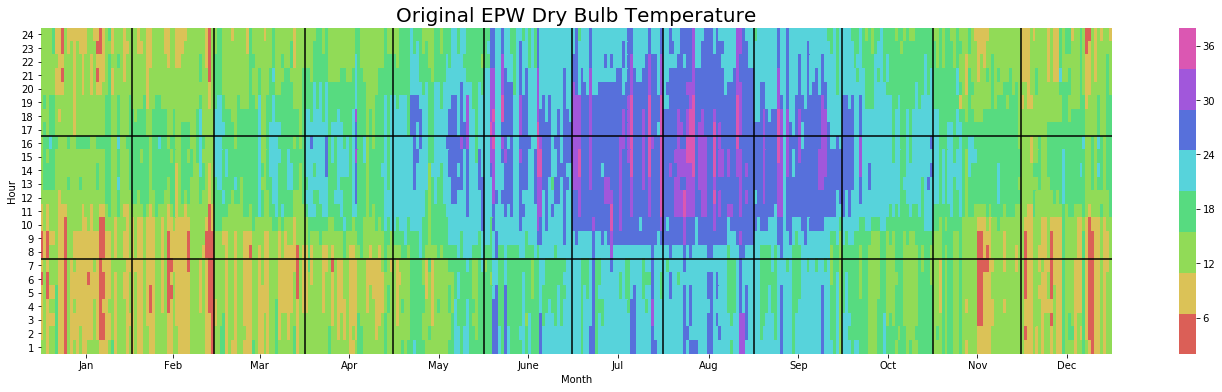

In [15]:
yearly_heatmap_plot(df_original, 'Dry_Bulb_Temperature', 'Original EPW Dry Bulb Temperature')

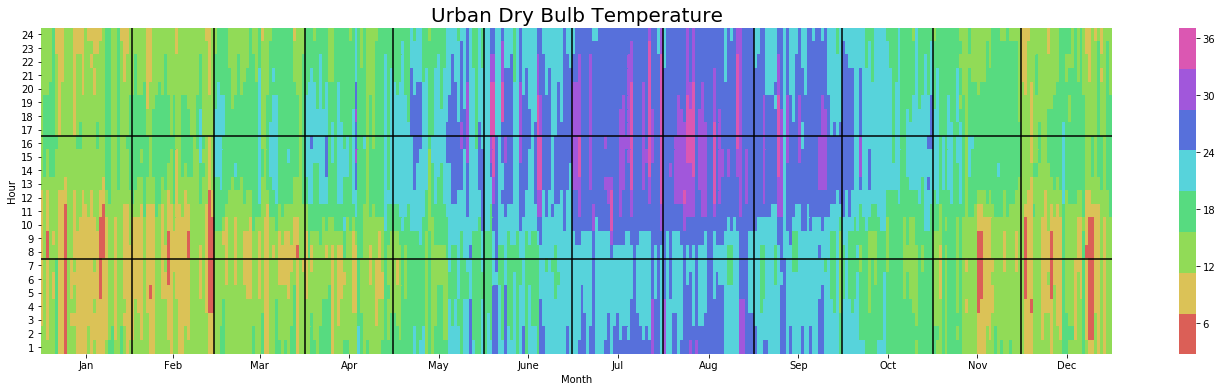

In [16]:
yearly_heatmap_plot(df_urban, 'Dry_Bulb_Temperature', 'Urban Dry Bulb Temperature')

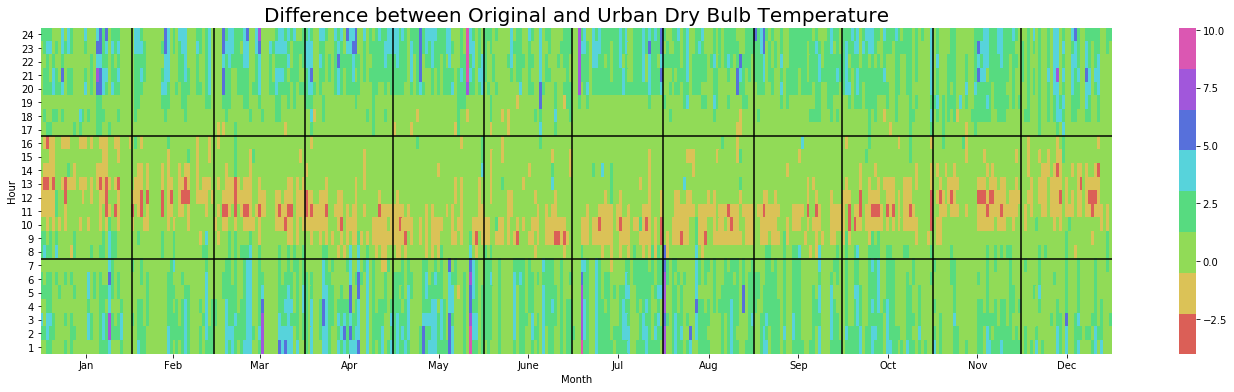

In [17]:
yearly_heatmap_plot(diff, 'Dry_Bulb_Temperature', 'Difference between Original and Urban Dry Bulb Temperature')

#### Relative Humidity

The impact of the Urban environment on `Relative Humidity` also follows a seasonal pattern whereby Summers are distinctly drier, especially once the sun has set.

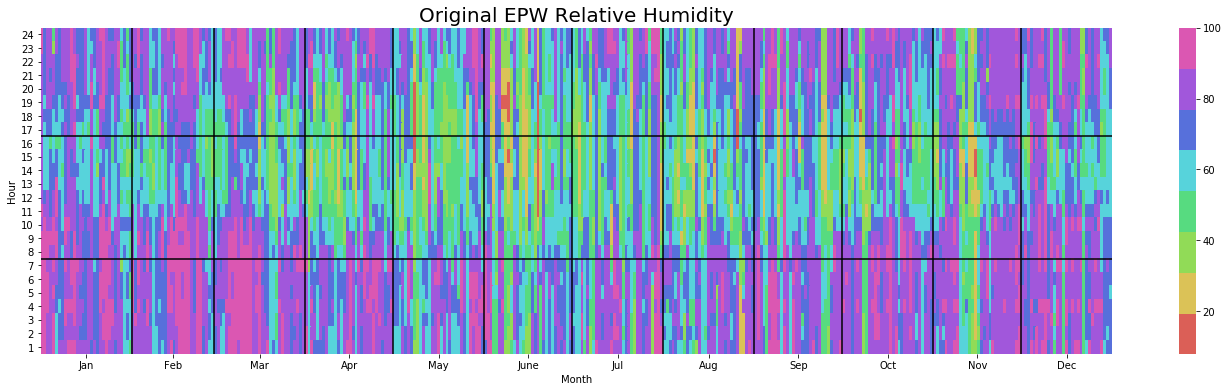

In [18]:
yearly_heatmap_plot(df_original, 'Relative_Humidity', 'Original EPW Relative Humidity')

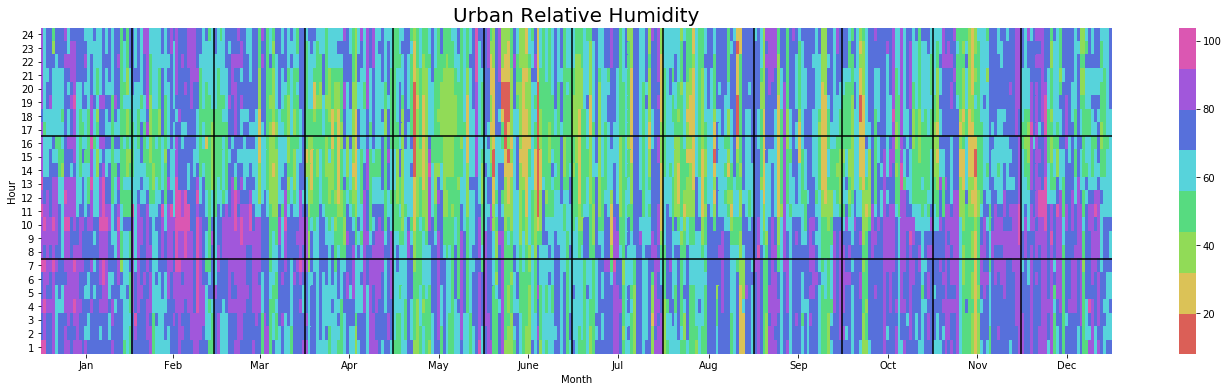

In [19]:
yearly_heatmap_plot(df_urban, 'Relative_Humidity', 'Urban Relative Humidity')

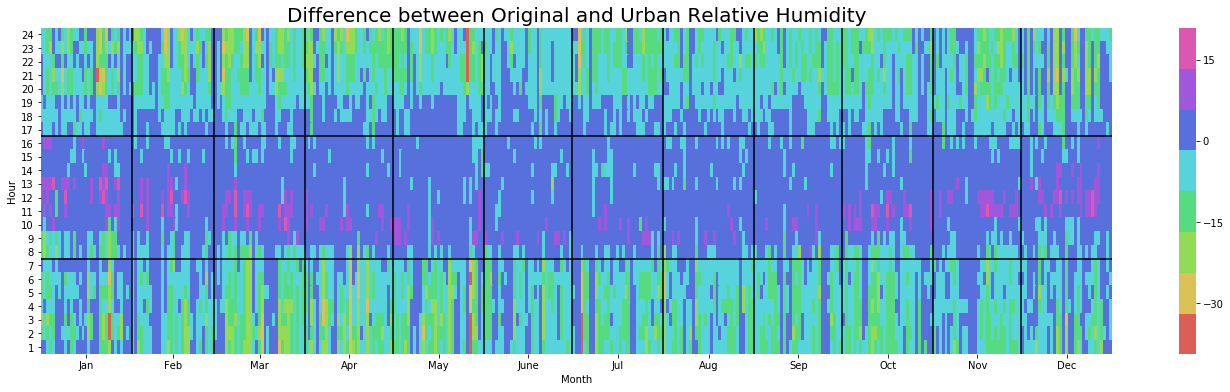

In [20]:
yearly_heatmap_plot(diff, 'Relative_Humidity', 'Difference between Original and Urban Relative Humidity')

## Wrapping it up

And that's us done folks. Hope you enjoyed the tutorial and look forward to showing you more of this stuff in Part 2 of this tutorial series where we will be running a parametric study using Dragonfly to inform urban design.